In [1]:
import os.path

import matplotlib.pyplot as plt
import seaborn as sns
import csv
import numpy as np
from os import listdir
import pickle
from astropy.io import fits
import pandas as pd
from PIL import Image
plt.rc('font',family='Times New Roman')
%matplotlib inline

In [2]:
def load_img(file):
    """
    加载图像，dat和fits均支持，不过仅支持CxHxW
    :param filename: 传入文件名，应当为CHW
    :return: 返回CHW的ndarray
    """
    if ".fits" in file:
        with fits.open(file) as hdul:
            return hdul[0].data.astype(np.float32)
    else:
        raise TypeError

def chw2hwc(img):
    ch1, ch2, ch3 = img[0], img[1], img[2]
    h, w = ch1.shape
    return np.concatenate((ch1.reshape(h, w, 1), ch2.reshape(h, w, 1), ch3.reshape(h, w, 1)), axis=2)

def hwc2chw(img):
    ch1, ch2, ch3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    return np.array((ch1, ch2, ch3))

In [4]:
plt_path = "/data/renhaoye/decals_2022/code/plt/"

In [5]:
raw_fits = listdir("/data/renhaoye/decals_2022/in_decals/fits/")

KeyboardInterrupt: 

In [6]:
decals_df = pd.read_csv("/data/renhaoye/decals_2022/dataset_decals.csv", index_col=0)
sdss_df = pd.read_csv("/data/renhaoye/decals_2022/dataset_sdss_match_decals.csv", index_col=0)

decals_dataset = [decals_df.query("func == 'train'"), decals_df.query("func == 'test'"), decals_df.query("func == 'valid'")]
sdss_dataset = [sdss_df.query("func == 'train'"), sdss_df.query("func == 'test'"), sdss_df.query("func == 'valid'")]

DECaLS示例图

In [ ]:
num = 7
col_num = 20
start_col = 190
data_dir = "/data/renhaoye/decals_2022/in_decals/decals_best/"
row_gap = np.ones((4, (col_num) * 256 + (col_num + 1 - 1) * 4, 3))
col_gap = np.ones((256, 4, 3))
row_output = None
for label in range(num):
    df = decals_dataset[0].query("label == %d" % label)
    col_output = None
    for col in range(start_col, start_col + col_num):
        ra, dec = df.iloc[col].ra, df.iloc[col].dec
        img = load_img(data_dir + str(ra) + "_" + str(dec) + ".fits")
        if (col-start_col) == 0:
            col_output = np.concatenate((chw2hwc(img), col_gap), axis=1)
        else:
            col_output = np.concatenate((col_output, col_gap, chw2hwc(img)), axis=1)
    if label == 0:
        row_output = col_output
    else:
        row_output = np.concatenate((row_output, row_gap, col_output), axis=0)
plt.figure(figsize=(15, 30))
plt.imshow(row_output)
plt.xticks([])
plt.yticks([])
plt.savefig(plt_path + "DECaLS数据示例.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

数据增强

In [ ]:
import math
DEGREE = 30
PIXEL = 5
import random
random.seed(1926)
class Img:
    def __init__(self, image, rows, cols, center=None):
        self.g_dst = None
        self.r_dst = None
        self.z_dst = None
        if center is None:
            center = [0, 0]
        self.dst = None
        self.g_src = image[0]
        self.r_src = image[1]
        self.z_src = image[2]
        self.transform = None
        self.rows = rows
        self.cols = cols
        self.center = center  # rotate center

    def Shift(self, delta_x, delta_y):  # 平移
        # delta_x>0 shift left  delta_y>0 shift top
        self.transform = np.array([[1, 0, delta_x],
                                   [0, 1, delta_y],
                                   [0, 0, 1]])

    def Flip(self):  # vertically flip
        self.transform = np.array([[-1, 0, self.rows - 1],
                                   [0, 1, 0],
                                   [0, 0, 1]])

    def Rotate(self, beta):  # rotate
        # beta<0 rotate clockwise
        self.transform = np.array([[math.cos(beta), -math.sin(beta), 0],
                                   [math.sin(beta), math.cos(beta), 0],
                                   [0, 0, 1]])

    def Process(self):
        self.g_dst = np.zeros((self.rows, self.cols), dtype=np.float32)
        self.r_dst = np.zeros((self.rows, self.cols), dtype=np.float32)
        self.z_dst = np.zeros((self.rows, self.cols), dtype=np.float32)
        for i in range(self.rows):
            for j in range(self.cols):
                src_pos = np.array([i - self.center[0], j - self.center[1], 1])
                [x, y, z] = np.dot(self.transform, src_pos)
                x = int(x) + self.center[0]
                y = int(y) + self.center[1]
                if x >= self.rows or y >= self.cols:
                    self.g_dst[i][j] = 0.
                    self.r_dst[i][j] = 0.
                    self.z_dst[i][j] = 0.
                else:
                    self.g_dst[i][j] = self.g_src[int(x)][int(y)]
                    self.r_dst[i][j] = self.r_src[int(x)][int(y)]
                    self.z_dst[i][j] = self.z_src[int(x)][int(y)]
        self.dst = np.array((self.g_dst, self.r_dst, self.z_dst))
def flip(img):
    height, width = img.shape[1:3]
    output = Img(img, height, width, [0, 0])
    output.Flip()
    output.Process()
    return output.dst
def rotate(img):
    seed = random.randint(-DEGREE, DEGREE)
    height, width = img.shape[1:3]
    output = Img(img, height, width, [height / 2, width / 2])
    output.Rotate(seed)
    output.Process()
    return output.dst
def shift(img):
    height, width = img.shape[1:3]
    output = Img(img, height, width, [0, 0])
    output.Shift(PIXEL, 0)
    output.Process()
    return output.dst

In [ ]:
df = decals_dataset[0].query("label == 6")
col = 204
ra, dec = df.iloc[col].ra, df.iloc[col].dec
data_dir = "/data/renhaoye/decals_2022/in_decals/decals_best/"
scaled = load_img(data_dir + str(ra) + "_" + str(dec) + ".fits")
print(data_dir + str(ra) + "_" + str(dec) + ".fits")
plt.figure(figsize=(4, 10))
plt.imshow(chw2hwc(scaled))
plt.xticks([])
plt.yticks([])
plt.savefig(plt_path + "MTF示例.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

In [ ]:
df = decals_dataset[0].query("label == 6")
col = 204
ra, dec = df.iloc[col].ra, df.iloc[col].dec
data_dir = "/data/renhaoye/decals_2022/in_decals/decals_best/"
img = load_img(data_dir + str(ra) + "_" + str(dec) + ".fits")
print(data_dir + str(ra) + "_" + str(dec) + ".fits")
flipped = flip(img)
rotated = rotate(img)
shifted = shift(img)
col_gap = np.ones((256, 4, 3))
col_output = np.concatenate((chw2hwc(img), col_gap, chw2hwc(flipped), col_gap, chw2hwc(rotated), col_gap, chw2hwc(shifted)), axis=1)
plt.figure(figsize=(10, 10))
plt.imshow(col_output)
plt.xticks([])
plt.yticks([])
plt.savefig(plt_path + "数据增强示例.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

SDSS示例图

In [ ]:
num = 7
col_num = 20
start_col = 190
data_dir = "/data/renhaoye/decals_2022/in_decals/sdss_agmtn_scaled/"
row_gap = np.ones((4, (col_num) * 256 + (col_num + 1 - 1) * 4, 3))
col_gap = np.ones((256, 4, 3))
row_output = None
for label in range(num):
    df = sdss_dataset[0].query("label == %d" % label)
    col_output = None
    for col in range(start_col, start_col + col_num):
        fname = df.iloc[col].sdss_loc.split("/")[-1]
        img = load_img(data_dir + fname)
        if (col-start_col) == 0:
            col_output = np.concatenate((chw2hwc(img), col_gap), axis=1)
        else:
            col_output = np.concatenate((col_output, col_gap, chw2hwc(img)), axis=1)
    if label == 0:
        row_output = col_output
    else:
        row_output = np.concatenate((row_output, row_gap, col_output), axis=0)
plt.figure(figsize=(15, 30))
plt.imshow(row_output)
plt.xticks([])
plt.yticks([])
plt.savefig(plt_path + "SDSS数据示例.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

画波长图

In [ ]:
from scipy.interpolate import interp1d
dir = "/data/renhaoye/decals_2022/code/plt/"
def load(path):
    wavelengths = []
    throughputs = []
    with open(path, "r") as r:
        x = r.readlines()
    for i in range(len(x)):
        wavelength, throughput = x[i].split(" ")[0], x[i].split(" ")[1].split("\n")[0]
        wavelengths.append(float(wavelength))
        throughputs.append(float(throughput))
    return np.array(wavelengths), np.array(throughputs)
bass_g_w, bass_g_t = load(dir + "BOK_BASS.g.dat")
bass_r_w, bass_r_t = load(dir + "BOK_BASS.r.dat")
mzls_z_w, mzls_z_t = load(dir + "KPNO_MzLS.z.dat")
decals_g_w, decals_g_t = load(dir + "CTIO_DECam.g.dat")
decals_r_w, decals_r_t = load(dir + "CTIO_DECam.r.dat")
decals_z_w, decals_z_t = load(dir + "CTIO_DECam.z.dat")
sdss_g_w, sdss_g_t = load(dir + "SLOAN_SDSS.g.dat")
sdss_r_w, sdss_r_t = load(dir + "SLOAN_SDSS.r.dat")
sdss_z_w, sdss_z_t = load(dir + "SLOAN_SDSS.z.dat")


def fit(x, y):
    new_x = np.linspace(np.min(x), np.max(x), 1000)
    func = interp1d(x, y, kind="cubic")
    new_y = func(new_x)
    return new_x, new_y

plt.figure(figsize=(15, 8))

# g
# color = "#44cef6"
sdss_g_x, sdss_g_y = fit(sdss_g_w, sdss_g_t)
plt.plot(sdss_g_x, sdss_g_y, label="SDSS_g", linestyle='-.')

decals_g_x, decals_g_y = fit(decals_g_w, decals_g_t)
plt.plot(decals_g_x, decals_g_y, label="DECaLS_g", linestyle='-')

bass_g_x, bass_g_y = fit(bass_g_w, bass_g_t)
plt.plot(bass_g_x, bass_g_y, label="BASS_g", linestyle='--')

# r
# color = "#ff7500" # f5a31f
sdss_r_x, sdss_r_y = fit(sdss_r_w, sdss_r_t)
plt.plot(sdss_r_x, sdss_r_y, label="SDSS_r", linestyle='-.')

decals_r_x, decals_r_y = fit(decals_r_w, decals_r_t)
plt.plot(decals_r_x, decals_r_y, label="DECaLS_r", linestyle='-')

bass_r_x, bass_r_y = fit(bass_r_w, bass_r_t)
plt.plot(bass_r_x, bass_r_y, label="BASS_r", linestyle='--')

# z
# color = "#9d2933"
sdss_z_x, sdss_z_y = fit(sdss_z_w, sdss_z_t)
plt.plot(sdss_z_x, sdss_z_y, label="SDSS_z", linestyle='-.')

decals_z_x, decals_z_y = fit(decals_z_w, decals_z_t)
plt.plot(decals_z_x, decals_z_y, label="DECaLS_z", linestyle='-', color="#758a99")

mzls_z_x, mzls_z_y = fit(mzls_z_w, mzls_z_t)
plt.plot(mzls_z_x, mzls_z_y, label="MzLS_z", linestyle='--', color="#f05654")

plt.xlabel("Wavelength(A)", fontsize=20)
plt.ylabel("Transmission", fontsize=20)
plt.ylim((0., 1.))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc="best", fontsize=12)
plt.savefig(plt_path + "数据集滤光片波长透过率.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

数据增强样本数量

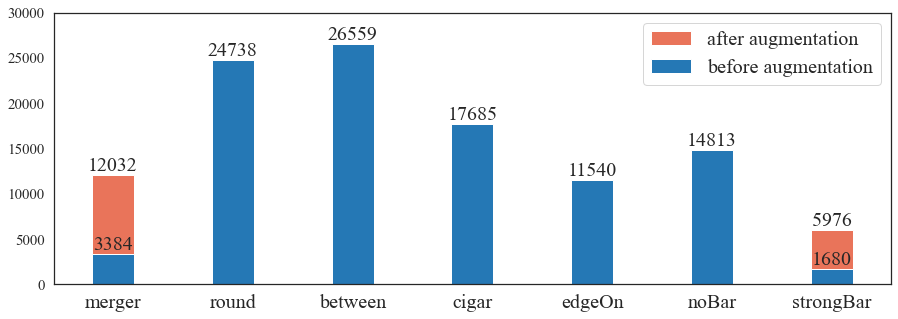

In [37]:
decals_df = pd.read_csv("/data/renhaoye/decals_2022/dataset_decals.csv", index_col=0)
sdss_df = pd.read_csv("/data/renhaoye/decals_2022/dataset_sdss_match_decals.csv", index_col=0)
merger = decals_df.query("label == 0")
smoothRounded = decals_df.query("label == 1")
smoothInBetween = decals_df.query("label == 2")
smoothCigarShaped = decals_df.query("label == 3")
edgeOn = decals_df.query("label == 4")
diskNoBar = decals_df.query("label == 5")
diskStrongBar = decals_df.query("label == 6")
num = [
    int(0.81 * len(merger)), int(0.81 * len(smoothRounded)), int(0.81 * len(smoothInBetween)),
    int(0.81 * len(smoothCigarShaped)), int(0.81 * len(edgeOn)),
    int(0.81 * len(diskNoBar)), int(0.81 * len(diskStrongBar))
]
label = [
    "merger", "round", "between",
    "cigar", "edgeOn","noBar", "strongBar"
]
num_2 = [
    int(0.72 * len(merger)) * 4, 0, 0, 0, 0, 0, int(0.72 * len(diskStrongBar)) * 4
]

plt.figure(figsize=(15, 5))
plt.bar(label, num_2, color="#e9745a", label="after augmentation", width=0.35)
plt.bar(label, num, color="#2578b5", label="before augmentation", width=0.35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.legend(loc="best", fontsize=20)
for a, b in zip(label, num_2):
    if a == "merger" or a == "strongBar":
        plt.text(a, b+1, b, ha='center', va='bottom', fontsize=20)
for a, b in zip(label, num):
    # if not (a == "merger" or a == "diskStrongBar"):
    plt.text(a, b+1, b, ha='center', va='bottom', fontsize=20)
plt.savefig(plt_path + "decals数据增强效果对比.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.ylim((0,30000))
plt.show()

In [ ]:
sdss_df = pd.read_csv("/data/renhaoye/decals_2022/dataset_sdss_match_decals.csv", index_col=0)
merger = sdss_df.query("label == 0")
smoothRounded = sdss_df.query("label == 1")
smoothInBetween = sdss_df.query("label == 2")
smoothCigarShaped = sdss_df.query("label == 3")
edgeOn = sdss_df.query("label == 4")
diskNoBar = sdss_df.query("label == 5")
diskStrongBar = sdss_df.query("label == 6")
num = [
    7231, 69334, 113773, 26547, 15900, 38575, 4041
]
label = [
    "merger", "round", "between",
    "cigar", "edgeOn","noBar", "strongBar"
]
plt.figure(figsize=(25, 12))
plt.bar(label, num, color="#2578b5", label="before")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.legend(loc="best", fontsize=20)
for a, b in zip(label, num):
    # if not (a == "merger" or a == "diskStrongBar"):
    plt.text(a, b+1, b, ha='center', va='bottom', fontsize=20)
plt.savefig(plt_path + "sdss数据增强效果对比.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

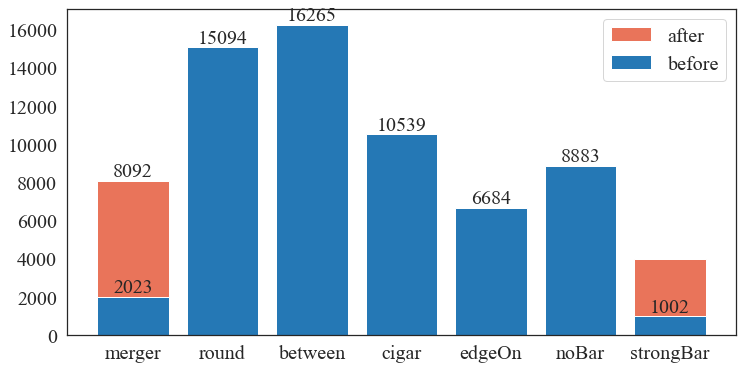

In [18]:
sdss_df = pd.read_csv("/data/renhaoye/decals_2022/dataset_sdss_match_decals.csv", index_col=0)
merger = sdss_df.query("label == 0")
smoothRounded = sdss_df.query("label == 1")
smoothInBetween = sdss_df.query("label == 2")
smoothCigarShaped = sdss_df.query("label == 3")
edgeOn = sdss_df.query("label == 4")
diskNoBar = sdss_df.query("label == 5")
diskStrongBar = sdss_df.query("label == 6")
num = [
    int(0.72 * len(merger)), int(0.72 * len(smoothRounded)), int(0.72 * len(smoothInBetween)),
    int(0.72 * len(smoothCigarShaped)), int(0.72 * len(edgeOn)),
    int(0.72 * len(diskNoBar)), int(0.72 * len(diskStrongBar))
]
label = [
    "merger", "round", "between",
    "cigar", "edgeOn","noBar", "strongBar"
]
num_2 = [
    int(0.72 * len(merger)) * 4, 0, 0, 0, 0, 0, int(0.72 * len(diskStrongBar)) * 4
]
plt.figure(figsize=(12, 8))
plt.bar(label, num_2, color="#e9745a", label="after")
plt.bar(label, num, color="#2578b5", label="before")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="best", fontsize=20)
for a, b in zip(label, num_2):
    if a == "merger" or a == "diskStrongBar":
        plt.text(a, b+1, b, ha='center', va='bottom', fontsize=20)
for a, b in zip(label, num):
    # if not (a == "merger" or a == "diskStrongBar"):
    plt.text(a, b+1, b, ha='center', va='bottom', fontsize=20)
plt.savefig(plt_path + "sdss数据增强效果对比.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

In [ ]:
len(merger)+len(smoothRounded)+len(smoothInBetween)+len(smoothCigarShaped)+len(edgeOn)+ len(diskNoBar)+len(diskStrongBar)

In [ ]:
decals_csv = "/data/renhaoye/decals_2022/fits.csv"
decals_df = pd.read_csv(decals_csv, index_col=0)
threshold = 0.5
merger = decals_df.query('merging_minor_disturbance_fraction > %f '
                               '| merging_major_disturbance_fraction > %f '
                               '| merging_merger_fraction > %f '
                               % (threshold, threshold, threshold))
smoothRounded = decals_df.query('smooth_or_featured_smooth_fraction >  %f '
                              '& how_rounded_round_fraction > %f' % (threshold, threshold))
smoothInBetween = decals_df.query('smooth_or_featured_smooth_fraction >  %f '
                                '& how_rounded_in_between_fraction > %f' % (threshold, threshold))
smoothCigarShaped = decals_df.query('smooth_or_featured_smooth_fraction > %f '
                                  '& how_rounded_cigar_shaped_fraction > %f' % (threshold, threshold))
edgeOn = decals_df.query('smooth_or_featured_featured_or_disk_fraction > %f '
                       '& disk_edge_on_yes_fraction > %f'
                       % (threshold, threshold))
diskNoBar = decals_df.query('smooth_or_featured_featured_or_disk_fraction > %f '
                          '& disk_edge_on_no_fraction > %f '
                          '& bar_no_fraction > %f '
                          % (threshold, threshold, threshold))
diskStrongBar = decals_df.query('smooth_or_featured_featured_or_disk_fraction > %f '
                              '& disk_edge_on_no_fraction > %f '
                              '&bar_strong_fraction > %f '
                              % (threshold, threshold, threshold))

In [ ]:
num = [
    len(merger), len(smoothRounded), len(smoothInBetween), len(smoothCigarShaped), len(edgeOn),
    len(diskNoBar), len(diskStrongBar)
]
label = [
    "merger", "smoothRounded", "smoothInBetween",
    "smoothCigarShaped", "edgeOn","diskNoBar", "diskStrongBar"
]
num_2 = [
    len(merger) * 4, 0, 0, 0, 0, 0, len(diskStrongBar) * 4
]
plt.figure(figsize=(24, 10))
# plt.bar(label, num_2, color="#e9745a", label="after")
plt.bar(label, num, color="#2578b5")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for a, b in zip(label, num):
    plt.text(a, b+1, b, ha='center', va='bottom', fontsize=20)
# plt.legend(loc="best", fontsize=20)
plt.savefig(plt_path + "数据增强效果对比(50%阈值).png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
redshift = np.concatenate((np.array(merger.redshift),
                np.array(merger.redshift),
                np.array(smoothRounded.redshift),
                np.array(smoothInBetween.redshift),
                np.array(smoothCigarShaped.redshift),
                np.array(edgeOn.redshift),
                np.array(diskNoBar.redshift),
                np.array(diskStrongBar.redshift),
                ))
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1, palette=None)
sns.set_style("whitegrid")
redshift = redshift[np.where((redshift > 0) & (redshift < 0.16))]
sns.histplot(redshift, stat="density", bins=50, shrink=0.8, kde=False)
# plt.hist(redshift, histtype="step", bins=30, density=True, range=(0, 0.16))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("redshift", fontsize=12)
plt.ylabel("percent", fontsize=12)
# plt.legend(loc="best")
plt.xlim((0, 0.152))
plt.tight_layout()
plt.show()

In [ ]:
petro_theta = np.concatenate((np.array(merger.petro_theta),
                np.array(merger.petro_theta),
                np.array(smoothRounded.petro_theta),
                np.array(smoothInBetween.petro_theta),
                np.array(smoothCigarShaped.petro_theta),
                np.array(edgeOn.petro_theta),
                np.array(diskNoBar.petro_theta),
                np.array(diskStrongBar.petro_theta),
                ))
petro_th50 = np.concatenate((np.array(merger.petro_th50),
                np.array(merger.petro_th50),
                np.array(smoothRounded.petro_th50),
                np.array(smoothInBetween.petro_th50),
                np.array(smoothCigarShaped.petro_th50),
                np.array(edgeOn.petro_th50),
                np.array(diskNoBar.petro_th50),
                np.array(diskStrongBar.petro_th50),
                ))
petro_th90 = np.concatenate((np.array(merger.petro_th90),
                np.array(merger.petro_th90),
                np.array(smoothRounded.petro_th90),
                np.array(smoothInBetween.petro_th90),
                np.array(smoothCigarShaped.petro_th90),
                np.array(edgeOn.petro_th90),
                np.array(diskNoBar.petro_th90),
                np.array(diskStrongBar.petro_th90),
                ))
# sns.set_theme(font='Times New Roman',font_scale=1.4)
# mag_r = mag_r[np.where((mag_r > 11) & (mag_r < 21))]
# sns.set("poster")
plt.rc('font',family='Times New Roman')
plt.figure(figsize=(10, 5))
plt.hist(petro_theta, density=True, bins=50, label="theta", histtype="step", range=(0, 24))
plt.hist(petro_th50, density=True, bins=50, label="th50", histtype="step", range=(0, 24))
plt.hist(petro_th90, density=True, bins=50, label="th90", histtype="step", range=(0, 24))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("mag_r", fontsize=20)
plt.ylabel("percent", fontsize=20)
plt.legend()
plt.show()

In [ ]:
mag_r = np.concatenate((np.array(merger.mag_r),
                np.array(merger.mag_r),
                np.array(smoothRounded.mag_r),
                np.array(smoothInBetween.mag_r),
                np.array(smoothCigarShaped.mag_r),
                np.array(edgeOn.mag_r),
                np.array(diskNoBar.mag_r),
                np.array(diskStrongBar.mag_r),
                ))
sns.set_theme(font='Times New Roman',font_scale=1, palette=None)
mag_r = mag_r[np.where((mag_r > 11) & (mag_r < 21))]
sns.set("poster")
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(mag_r, stat="density", kde=False, shrink=0.8, bins=50)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("petro_th90", fontsize=12)
plt.ylabel("percent", fontsize=12)
plt.show()

In [ ]:
from astropy.io import fits
with fits.open("/data/renhaoye/decals_2022/MGS_out_DECaLS.fits") as hdul:
    data = np.array(hdul[1].data)
    out = np.zeros((data.shape[0],10))
    """
    [('VID', '>i4'), ('RA', '>f8'), ('DEC', '>f8'), ('PETROMAG', '>f8', (5,)), ('MODELMAG', '>f8', (5,)), ('FIBERMAG', '>f8', (5,)), ('VAGC_SELECT', '>i4'), ('KCORRECT', '>f8', (5,)), ('Z', '>f8'), ('ZFLAG', '>f8')]
    """
    for i in range(data.shape[0]):
        out[i,0] = data[i]["VID"]
        out[i,1] = data[i]["RA"]
        out[i,2] = data[i]["DEC"]
        out[i,3] = data[i]["PETROMAG"][2]
        out[i,4] = data[i]["MODELMAG"][3]
        out[i,5] = data[i]["FIBERMAG"][3]
        out[i,6] = data[i]["VAGC_SELECT"]
        out[i,7] = data[i]["KCORRECT"][3]
        out[i,8] = data[i]["Z"]
        out[i,9] = data[i]["ZFLAG"]
out = pd.DataFrame(out, columns=["VID","ra","dec","petro_mag","model_mag","fiber_mag","vagc_select","k_correct", "z", "z_flag"])

In [ ]:
plt.figure(figsize=(10, 5))
z = np.array(out.z)
z = z[np.where((z > 0) & (z < 0.32))]
sns.histplot(z, stat="density", bins=45, shrink=0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("redshift", fontsize=12)
plt.ylabel("percent", fontsize=12)
# plt.legend(loc="best")
plt.xlim((0, 0.32))
plt.tight_layout()
plt.show()

画loss曲线

In [11]:
def get_loss(fname):
    train_loss = []
    valid_loss = []
    kappa = []
    with open("/data/renhaoye/decals_2022/%s.log" % fname, "r") as r:
        lines = r.readlines()
    for line in lines:
        if "loss" in line:
            if "test" in line:
                valid_loss.append(float(line[11:-2]))
            else:
                train_loss.append(float(line[7:-2]))
        if "kappa" in line:
            kappa.append(float(line[8:-2]))
        else:
            pass
    train_kappa, test_kappa = [], []
    # for i in range(len(kappa)):
    #     if (i % 2) == 0:
    #         train_kappa.append(kappa[i])
    #     else:
    #         test_kappa.append(kappa[i])
    # return np.array(train_loss), np.array(valid_loss), np.array(train_kappa), np.array(test_kappa)
    if len(kappa)==0:
        return np.array(train_loss), np.array(valid_loss)
    else:
        return np.array(train_loss), np.array(valid_loss), np.array(kappa)

In [ ]:
"""baseline"""
baseline_train_loss, baseline_valid_loss = get_loss("baseline")
idx = np.arange(0, len(baseline_train_loss), 1)
plt.figure(figsize=(10, 5))
plt.plot(idx, baseline_train_loss, label="train loss")
plt.plot(idx, baseline_valid_loss, label="valid loss")
train_min_idx = np.argmin(baseline_train_loss)
valid_min_idx = np.argmin(baseline_valid_loss)
plt.scatter(x = train_min_idx, y = baseline_train_loss[train_min_idx])
plt.scatter(x = valid_min_idx, y = baseline_valid_loss[valid_min_idx])
plt.xlabel("epoch", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.ylim((0, 0.4))
plt.xticks(idx, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
# plt.grid(axis="both")
plt.savefig(plt_path + "baseline_loss.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

In [ ]:
"""NoAgmtn"""
sns.set_theme(style="white", font='Times New Roman',font_scale=1.4, palette=None)
baseline_train_loss, baseline_valid_loss = get_loss("NoAgmtn")
idx = np.arange(0, len(baseline_train_loss), 1)
plt.figure(figsize=(10, 5))
plt.plot(idx, baseline_train_loss, label="train loss")
plt.plot(idx, baseline_valid_loss, label="valid loss")
train_min_idx = np.argmin(baseline_train_loss)
valid_min_idx = np.argmin(baseline_valid_loss)
plt.scatter(x = train_min_idx, y = baseline_train_loss[train_min_idx])
plt.scatter(x = valid_min_idx, y = baseline_valid_loss[valid_min_idx])
plt.xlabel("epoch", fontsize=20)
plt.ylabel("loss", fontsize=20)
# plt.ylim((0, 0.4))
# plt.xlim((0, 20))
plt.xticks(idx, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis="both")
plt.savefig(plt_path + "NoAgmtn_loss.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

In [ ]:
"""BEST"""
sns.set_theme(style="white", font='Times New Roman',font_scale=1.4, palette=None)
best_train_loss, best_valid_loss, best_train_kappa, best_test_kappa = get_loss("best")
idx = np.arange(0, len(best_train_loss), 1)
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(idx, best_train_loss, label="train loss")
plt.plot(idx, best_valid_loss, label="valid loss")
train_min_idx = np.argmin(best_train_loss)
valid_min_idx = np.argmin(best_valid_loss)
plt.scatter(x = train_min_idx, y = best_train_loss[train_min_idx])
plt.scatter(x = valid_min_idx, y = best_valid_loss[valid_min_idx])
plt.xlabel("epoch", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.xticks(idx, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis="both")
plt.subplot(122)
plt.plot(idx, best_train_kappa, label="train kappa")
plt.plot(idx, best_test_kappa, label="test kappa")
train_max_idx = np.argmax(best_train_kappa)
test_max_idx = np.argmax(best_test_kappa)
plt.scatter(x = train_max_idx, y = best_train_kappa[train_max_idx])
plt.scatter(x = test_max_idx, y = best_test_kappa[test_max_idx])
plt.xlabel("epoch", fontsize=20)
plt.ylabel("kappa", fontsize=20)
plt.xticks(idx, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis="both")
plt.savefig(plt_path + "NoAgmtn_loss.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

In [ ]:
def mdb(num_samples: list):
    sum = 0
    for i in num_samples:
        sum += i
    for i in range(len(num_samples)):
        num_samples[i] = num_samples[i] / sum
    median = np.median(num_samples)
    print(median)
    for i in range(len(num_samples)):
        num_samples[i] = median / num_samples[i]
    return num_samples

各准确率变化

In [ ]:
"""best2"""
sns.set_theme(style="white", font='Times New Roman',font_scale=1.4, palette=None)
best_train_loss, best_valid_loss, best_test_kappa = get_loss("best_2")
idx = np.arange(0, len(best_train_loss), 1)
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(idx, best_train_loss, label="train loss")
plt.plot(idx, best_valid_loss, label="valid loss")
train_min_idx = np.argmin(best_train_loss)
valid_min_idx = np.argmin(best_valid_loss)
plt.scatter(x = train_min_idx, y = best_train_loss[train_min_idx])
plt.scatter(x = valid_min_idx, y = best_valid_loss[valid_min_idx])
plt.xlabel("epoch", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.xticks(idx, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis="both")
plt.subplot(122)
plt.plot(idx, best_test_kappa, label="test kappa")
test_max_idx = np.argmax(best_test_kappa)
plt.scatter(x = test_max_idx, y = best_test_kappa[test_max_idx])
plt.xlabel("epoch", fontsize=20)
plt.ylabel("kappa", fontsize=20)
plt.xticks(idx, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis="both")
plt.savefig(plt_path + "best2.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

In [ ]:
"""BEST"""
merger = [0.76, 0.88, 0.86, 0.81, 0.85, 0.71, 0.76, 0.82, 0.87, 0.87, 0.91, 0.76, 0.83, 0.85,
          0.71, 0.91, 0.81, 0.85, 0.83, 0.76, 0.77]
round = [0.99, 0.96, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.97, 0.99, 0.99, 0.99, 1, 0.99, 0.99,
         0.99, 0.99, 0.99, 0.99, 0.99, 0.99]
inbetween = [0.98, 0.93, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.92, 0.98, 0.96, 0.98, 0.98, 0.99,
             0.99, 0.98, 0.99, 0.97, 0.98, 0.99, 0.99]
cigarshaped = [0.84, 0.88, 0.96, 0.91, 0.87, 0.97, 0.92, 0.95, 0.95, 0.88, 0.84, 0.92, 0.91, 0.92,
               0.94, 0.9, 0.95, 0.96, 0.93, 0.92, 0.94]
edgeon = [0.9, 0.89, 0.81, 0.83, 0.95, 0.78, 0.89, 0.82, 0.84, 0.91, 0.93, 0.88, 0.9, 0.86, 0.85,
          0.88, 0.83, 0.77, 0.86, 0.89, 0.88]
nobar = [0.9, 0.92, 0.88, 0.9, 0.83, 0.9, 0.93, 0.91, 0.91, 0.92, 0.89, 0.9, 0.89, 0.9, 0.93,
         0.88, 0.9, 0.91, 0.92, 0.91, 0.9]
strongbar = [0.86, 0.91, 0.98, 0.91, 0.98, 0.9, 0.96, 0.93, 0.96, 0.95, 0.96, 0.91, 0.94, 0.94,
             0.93, 0.88, 0.92, 0.95, 0.93, 0.94, 0.92]
idx = list(np.arange(0, 21, 1))
plt.figure(figsize=(20, 10))
plt.plot(idx, merger, label="merger")
plt.plot(idx, round, label="round")
plt.plot(idx, inbetween, label="inbetween")
plt.plot(idx, cigarshaped, label="cigarshaped")
plt.plot(idx, edgeon, label="edgeon")
plt.plot(idx, nobar, label="nobar")
plt.plot(idx, strongbar, label="strongbar")
plt.xticks(idx, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("acc", fontsize=20)
plt.legend(loc="best", fontsize=20)
# from matplotlib.ticker import MaxNLocator
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylim(0.1, 1)
plt.grid()
plt.show()

In [7]:
import pickle
with open("/data/renhaoye/decals_2022/trained_model/x_ception-LR_0.0001-LS_focal_loss-CLS_7-BSZ_32-OPT_AdamW-BEST_2/cfm/epoch_3_test.dat", "rb") as r:
    data = pickle.load(r)

In [8]:
def cf_map(cf_matrix):
    classes = (
        "merger", "round", "between", "cigar",
        "edgeOn", "noBar", "strongBar")
    df_cm = pd.DataFrame(cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis],
                         index=[i for i in classes],
                         columns=[i for i in classes])
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.3f')

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rc('font',family='Times New Roman')
%matplotlib inline

In [12]:
"""best2"""
sns.set_theme(style="white", font='Times New Roman',font_scale=1.4, palette=None)
best_train_loss, best_valid_loss, best_test_kappa = get_loss("best_2")
idx = np.arange(0, len(best_train_loss), 1)
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(idx, best_train_loss, label="train loss")
plt.plot(idx, best_valid_loss, label="valid loss")
train_min_idx = np.argmin(best_train_loss)
valid_min_idx = np.argmin(best_valid_loss)
plt.scatter(x = train_min_idx, y = best_train_loss[train_min_idx])
plt.scatter(x = valid_min_idx, y = best_valid_loss[valid_min_idx])
plt.xlabel("epoch", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.xticks(idx, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis="both")
plt.subplot(122)
plt.plot(idx, best_test_kappa, label="test kappa")
test_max_idx = np.argmax(best_test_kappa)
plt.scatter(x = test_max_idx, y = best_test_kappa[test_max_idx])
plt.xlabel("epoch", fontsize=20)
plt.ylabel("kappa", fontsize=20)
plt.xticks(idx, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis="both")
plt.savefig(plt_path + "best2.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/data/renhaoye/decals_2022/best_2.log'

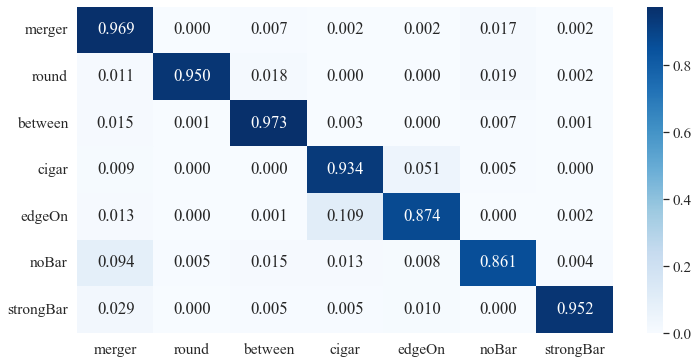

In [13]:
with open("/data/renhaoye/decals_2022/trained_model/x_ception-LR_0.0001-LS_focal_loss-CLS_7-BSZ_32-OPT_AdamW-BEST_2/cfm/epoch_6_test.dat", "rb") as r:
    data = pickle.load(r)
plt.figure(figsize=(12, 6))
cf_map(data)

In [14]:
with open("/data/renhaoye/decals_2022/trained_model/x_ception-LR_0.0001-LS_focal_loss-CLS_7-BSZ_32-OPT_AdamW-Baseline/cfm/epoch_6_test.dat", "rb") as r:
    data = pickle.load(r)
plt.figure(figsize=(12, 6))
cf_map(data)

FileNotFoundError: [Errno 2] No such file or directory: '/data/renhaoye/decals_2022/trained_model/x_ception-LR_0.0001-LS_focal_loss-CLS_7-BSZ_32-OPT_AdamW-Baseline/cfm/epoch_6_test.dat'

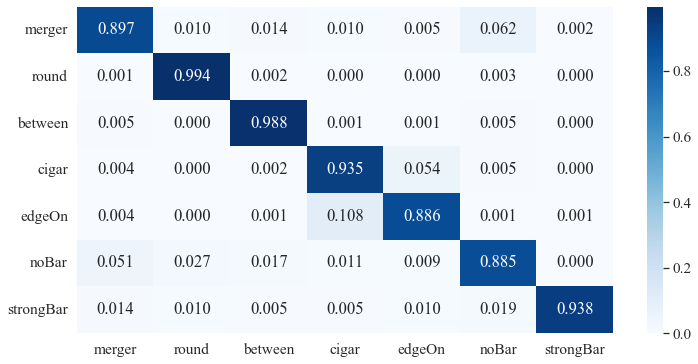

In [15]:

with open("/data/renhaoye/decals_2022/trained_model/x_ception-LR_0.0001-LS_focal_loss-CLS_7-BSZ_32-OPT_AdamW-BEST_2/cfm/epoch_5_test.dat", "rb") as r:
    data = pickle.load(r)
plt.figure(figsize=(12, 6))
cf_map(data)

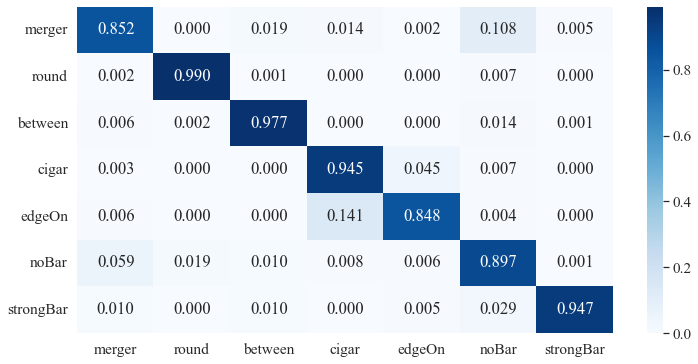

In [24]:
with open("/data/renhaoye/decals_2022/trained_model/x_ception-LR_0.0001-LS_focal_loss-CLS_7-BSZ_32-OPT_AdamW-BEST_2/cfm/epoch_20_test.dat", "rb") as r:
    data = pickle.load(r)
plt.figure(figsize=(12, 6))
cf_map(data)

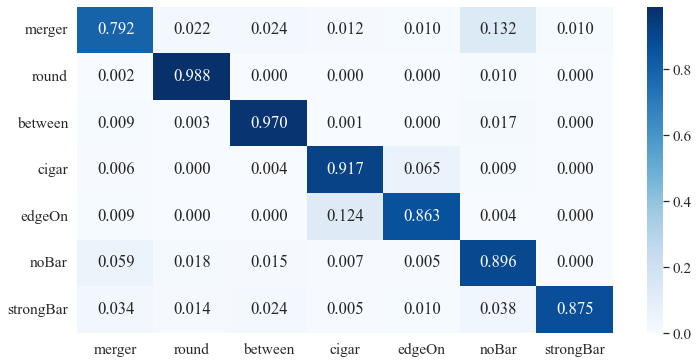

In [44]:
with open("/data/renhaoye/decals_2022/trained_model/x_ception-LR_0.0001-LS_focal_loss-CLS_7-BSZ_32-OPT_AdamW-masked/cfm/epoch_13_test.dat", "rb") as r:
    data = pickle.load(r)
plt.figure(figsize=(12, 6))
cf_map(data)

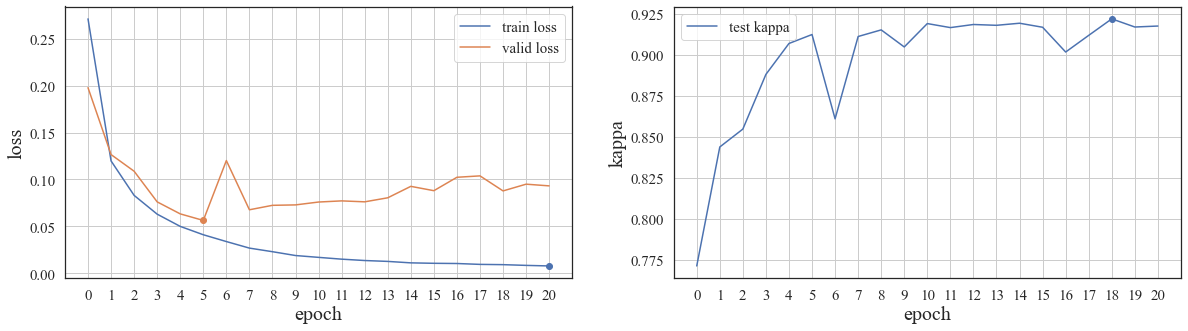

In [45]:
"""masked"""
sns.set_theme(style="white", font='Times New Roman',font_scale=1.4, palette=None)
best_train_loss, best_valid_loss, best_test_kappa = get_loss("masked")
idx = np.arange(0, len(best_train_loss), 1)
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(idx, best_train_loss, label="train loss")
plt.plot(idx, best_valid_loss, label="valid loss")
train_min_idx = np.argmin(best_train_loss)
valid_min_idx = np.argmin(best_valid_loss)
plt.scatter(x = train_min_idx, y = best_train_loss[train_min_idx])
plt.scatter(x = valid_min_idx, y = best_valid_loss[valid_min_idx])
plt.xlabel("epoch", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.xticks(idx, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis="both")
plt.subplot(122)
plt.plot(idx, best_test_kappa, label="test kappa")
test_max_idx = np.argmax(best_test_kappa)
plt.scatter(x = test_max_idx, y = best_test_kappa[test_max_idx])
plt.xlabel("epoch", fontsize=20)
plt.ylabel("kappa", fontsize=20)
plt.xticks(idx, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis="both")
plt.savefig(plt_path + "best2.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()